<a href="https://colab.research.google.com/github/HinePo/Kaggle-Competition-Digit-Reconigzer/blob/main/KC_Digit_Reconigzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
random_seed = 0 # Set the random seed

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator # data augmentation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import itertools # used to plot confusion matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
# Load the data
train = pd.read_csv("/content/drive/My Drive/Colab Files/Digit Recognizer/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Files/Digit Recognizer/test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Features and Target

Train and test images (28px x 28px) were provided as 1D vectors of 784 values (csv):

In [ ]:
# features
X_train = train.drop(['label'], axis = 1)
X_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# target
y_train = train['label']
y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

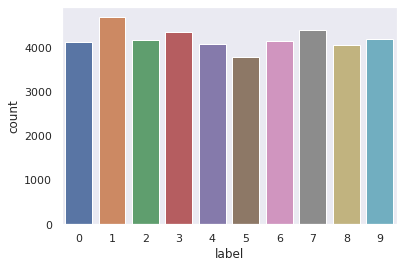

In [ ]:
# seems balanced
sns.set_style("dark")
sns.countplot(y_train)

In [ ]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# Data Pre-processing

## Missing values

In [ ]:
X_train.isnull().values.any()

False

In [ ]:
y_train.isnull().values.any()

False

## Normalization

Dataset description: "Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive."

Grayscale normalization to reduce the effect of illumination's differences.

Also, the CNN converges faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the lightness/darkness of the images: max brightness is 255
X_train = X_train / 255.0 # don't normalize column 'label' (target)
test = test / 255.0

In [ ]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Reshape arrays into 28x28 pixel images

Train and test images (28px x 28px) have been stocked into pandas.Dataframe as 1D vectors of 784 values (csv). So we reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it uses only one channel. For RGB images, there are 3 channels: we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channels = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [ ]:
# example 
X_train[4,6]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.04313725],
       [0.81568627],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.99215686],
       [0.41960784],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

## Label Encoding

In [ ]:
y_train
# 42.000 images containing digits from 0-9 (10 classes)

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

# Split

Since we have 42.000 training images of balanced classes/labels, a random split of the train set doesn't cause some labels to be over represented in the validation set.

Be carefull with some imbalanced datasets: a simple random split could cause inaccurate evaluation during the validation. In this case, just use stratify = True option in train_test_split function.

In [ ]:
# Split the train and the validation set for fitting and evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = random_seed)

# Visualizing some images

In [ ]:
# X_train[112]
# too big to output...

In [ ]:
# all the pixels (array in csv) for the 112th image
# X_train[112]    # too big...
X_train[112].shape

(28, 28, 1)

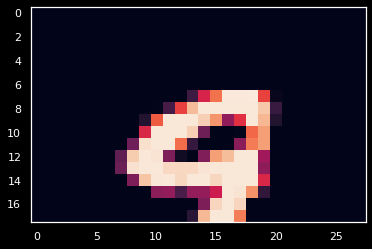

In [ ]:
# visualize the 112th image: 18 px in rows, all pixels in columns, greyscale
plt.style.use(['dark_background'])
plt.imshow(X_train[112][:18, :, 0])

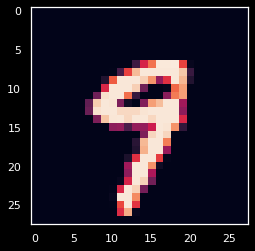

In [ ]:
# visualize the 112th image: just reshape
plt.style.use(['dark_background'])
plt.imshow((X_train[112]).reshape((28,28)))

In [ ]:
# digit above is a 9
y_train[112]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

# Data Augmentation

In order to avoid the overfitting problem, we need to expand artificially our handwritten digit dataset, and make our existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example: the number is not centered; the scale is not the same (some who write with big/small numbers); the image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important: Without data augmentation I obtained an accuracy of 98.11%. With data augmentation I achieved 99.67% of accuracy.

In [ ]:
# data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image (0.1 = 10%)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

For the data augmentation, I chose to :

*   Randomly rotate some training images by 15 degrees;
*   Randomly shift images horizontally by 10% of the width;
*   Randomly shift images vertically by 10% of the height;

I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

# Convolutional Neural Network (CNN)

Conv2D: The first layer is a convolutional (Conv2D) layer. It is like a set of learnable filters. I chose to set 32 filters for the first two conv2D layers and 64 filters for the last two. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

MaxPool2D: The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time). The higher the pooling dimension, the more important the downsampling is.

Conv2D + MaxPool2D: Combining convolutional and pooling layers increases the CNN capacity to combine local features and learn more global features of the image.

Droput: Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

Relu: 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

Flatten: The Flatten layer is used to convert the final feature maps into one single 1D vector. This flattening step is needed so that you can make use of fully connected layers (Dense) after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

Dense: In the end I used the features in two fully-connected (Dense) layers which is just an artificial neural network (ANN) classifier.

Softmax activation: In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [ ]:
# Keras CNN
# architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Once our layers are added to the model, we need to set up a score function, a loss function and an optimization algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the predicted labels and the groud-truth. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimize the loss.

I chose RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressiveness, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) # default parameters

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## Callbacks

In order to make the optimizer converge faster and closest to the global minimum of the loss function, I used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher the LR, the bigger the steps and the quicker the convergence. However the sampling is very poor with a high LR and the optimizer could probably fall into a local minima.

It's better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, I decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, I chose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [ ]:
# Set a learning rate annealer
# helps the net to converge faster to a global minima

# If we use the ReduceLROnPlateau callback, we can speed up the training by starting with a higher LR,
# because it will less likely to pass through the global minima and converge to a local minima

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# If we use the EarlyStopping callback, we can safely choose 
# the number of epochs, because we won't train the model longer than necessary

earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=5,
                             verbose=1,
                             mode='auto')

The EarlyStopping callback will stop training once triggered, but the model at the end of training may not be the model with best performance on the validation dataset.

An additional callback is required that will save the best model observed during training for later use. This is the ModelCheckpoint callback.

The ModelCheckpoint callback is flexible in the way it can be used, but in this case we will use it only to save the best model observed during training as defined by a chosen performance measure on the validation dataset.

Saving and loading models requires that HDF5 support has been installed on your workstation. It may be interesting to know the value of the performance measure and at what epoch the model was saved. This can be printed by the callback by setting the “verbose” argument to “1“.

In [ ]:
# saves best model on working directory
# It also saves the best weights, so the the model can be used
# as as pre-trained model in the future

# If we use the ModelCheckpoint callback, we can safely choose 
# the patience in the EarlyStopping callback, because the best model will be saved anyways

mc = ModelCheckpoint('best_model.h5', 
                     monitor = 'val_accuracy', 
                     mode = 'max', 
                     verbose = 1, 
                     save_best_only = True)

## Fit CNN

In [ ]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 100

In [ ]:
# Fit the model with augmented data (datagen)
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                              epochs = epochs, 
                              validation_data = (X_val, y_val),
                              verbose = 2, 
                              steps_per_epoch = X_train.shape[0] // batch_size, 
                              callbacks = [learning_rate_reduction, earlystopper, mc])

Epoch 1/30
 - 11s - loss: 0.4329 - accuracy: 0.8585 - val_loss: 0.0695 - val_accuracy: 0.9786

Epoch 00001: val_accuracy improved from -inf to 0.97857, saving model to best_model.h5
Epoch 2/30
 - 9s - loss: 0.1304 - accuracy: 0.9598 - val_loss: 0.0496 - val_accuracy: 0.9860

Epoch 00002: val_accuracy improved from 0.97857 to 0.98595, saving model to best_model.h5
Epoch 3/30
 - 9s - loss: 0.0984 - accuracy: 0.9706 - val_loss: 0.0301 - val_accuracy: 0.9890

Epoch 00003: val_accuracy improved from 0.98595 to 0.98905, saving model to best_model.h5
Epoch 4/30
 - 9s - loss: 0.0864 - accuracy: 0.9742 - val_loss: 0.0343 - val_accuracy: 0.9895

Epoch 00004: val_accuracy improved from 0.98905 to 0.98952, saving model to best_model.h5
Epoch 5/30
 - 9s - loss: 0.0760 - accuracy: 0.9771 - val_loss: 0.0399 - val_accuracy: 0.9871

Epoch 00005: val_accuracy did not improve from 0.98952
Epoch 6/30
 - 9s - loss: 0.0673 - accuracy: 0.9802 - val_loss: 0.0283 - val_accuracy: 0.9914

Epoch 00006: val_accura

## Evaluation

In [ ]:
history.history

{'accuracy': [0.85851854,
  0.9597884,
  0.9706085,
  0.97415346,
  0.97708994,
  0.98015875,
  0.9819577,
  0.98161376,
  0.9824603,
  0.9824868,
  0.986746,
  0.98777777,
  0.9873545,
  0.9873016,
  0.98777777,
  0.98804235,
  0.988836,
  0.9893915,
  0.9903968,
  0.99079365,
  0.98986775,
  0.98960316,
  0.99103177,
  0.9901058,
  0.99187833,
  0.9913757,
  0.9911905],
 'loss': [0.43286621124143637,
  0.13042716399603893,
  0.09841347660958058,
  0.0864027258336406,
  0.0759618604006295,
  0.06730845410970566,
  0.06655026203521562,
  0.06008247597014935,
  0.061647308644809065,
  0.059492198268084655,
  0.045638863269237204,
  0.043257109143293254,
  0.04500893792340768,
  0.04303232806740284,
  0.04061710569920097,
  0.04243006287700073,
  0.03779134177448839,
  0.03648311341750847,
  0.03443651150278538,
  0.03459117766437379,
  0.036163681718765966,
  0.035113026146843494,
  0.031596167906336535,
  0.03287663916657154,
  0.02909445541645351,
  0.029938424872982847,
  0.028249008

## Loss and Accuracy Plots

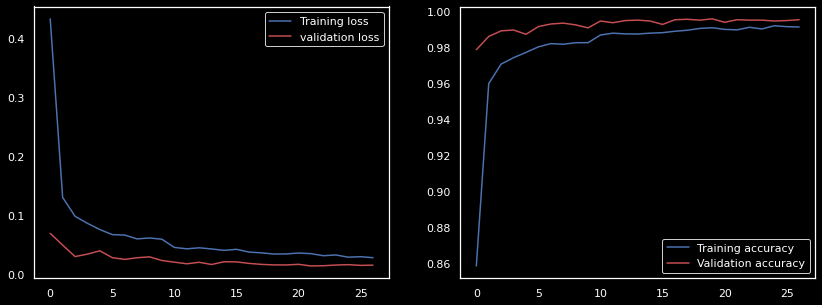

In [ ]:
# Plot the loss and accuracy curves for training and validation 
plt.style.use(['dark_background'])
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The model reaches almost 99% accuracy on the validation dataset after 2 epochs.

The validation accuracy is greater than the training accuracy almost evry time during the training. That means that our model does not overfit the training set.

# Best model

In [ ]:
# load the saved model
saved_model = load_model('/content/best_model.h5')

saved_model # use this variable to use the model with best results (ModelCheckpoint callback)

In [ ]:
# train (saved model)
train_loss, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)

# validation (saved model)
valid_loss, valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train Accuracy: %.4f, \n\nValidation Accuracy: %.4f' % (train_acc, valid_acc))

Train Accuracy: 0.9966, 

Validation Accuracy: 0.9957


## Confusion Matrix

In [ ]:
""" This function prints and plots the confusion matrix.
Normalization can be applied by setting 'normalize=True'. """

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
  plt.figure(figsize = (12,6))

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

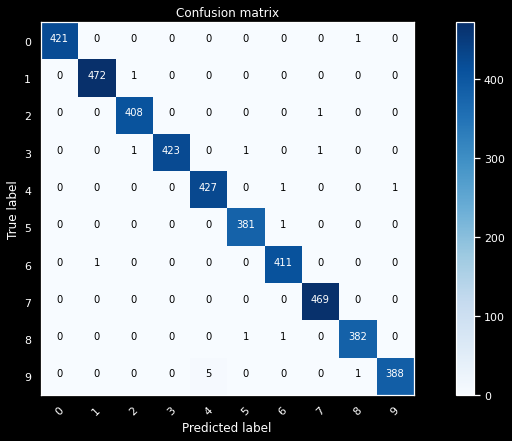

In [ ]:
y_pred = saved_model.predict(X_val) # Predict the values from the validation dataset
y_pred_classes = np.argmax(y_pred, axis = 1) # Convert predictions classes to one hot vectors 
y_true = np.argmax(y_val, axis = 1) # Convert validation observations to one hot vectors
confusion_mtx = confusion_matrix(y_true, y_pred_classes) # compute the confusion matrix

# plot the confusion matrix (call function)
plt.style.use(['dark_background'])
plot_confusion_matrix(confusion_mtx, classes = range(10), normalize = False) 

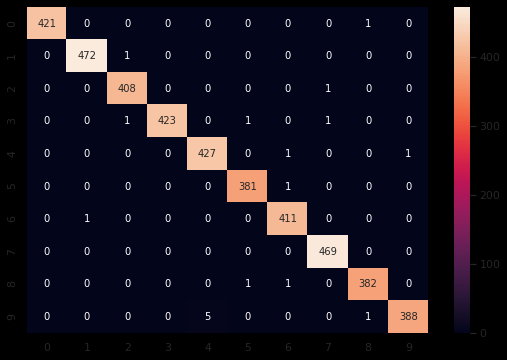

In [ ]:
plt.figure(figsize = (9,6))
sns.set_style("dark")
sns.heatmap(confusion_mtx, annot=True, fmt='d')

# Visualizing errors

We can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4.200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometimes it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate the errors.

I want to see the most important errors. For that purpose I need to get the difference between the probabilities of real values and the predicted ones in the results.

<Figure size 864x1440 with 0 Axes>

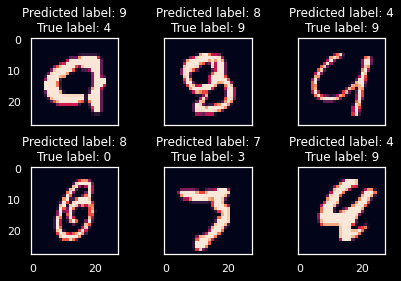

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""

    plt.figure(figsize=(12, 20))
    
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label: {}\nTrue label: {}".format(pred_errors[error],obs_errors[error]))
            n += 1

    plt.tight_layout()

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors (call function)
plt.style.use(['dark_background'])
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

# Predict

In [ ]:
# predict results

# last model (from last epoch)
# results = model.predict(test)

# saved model (best model)
results = saved_model.predict(test)

# select the index with the maximum probability (predicted class)
results = np.argmax(results, axis = 1)

results = pd.Series(results, name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis = 1)

submission.to_csv("cnn_digit_datagen.csv", index=False)

In [ ]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
submission.shape

(28000, 2)

# Improvements

How to further improve the results:
1. Change model / layers / architecture
2. Change Training hyper-parameters (Tuning): LR, epochs, batch
3. Change Callbacks parameters
4. Change data augmentation settings